In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import math
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import cv2
import copy
##Checking for GPU: 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu" )
print(torch.cuda.get_device_name(0))
import seaborn as sns
import pylab
import gzip
import pickle



Tesla K80


In [ ]:
def confusion(actual,assign):
  confusion_arr = torch.zeros(10,10)
  for j in range(len(actual)):
    for i in range(len(actual[j])):
      confusion_arr[actual[j][i]][assign[j][i]] += 1
    
  return confusion_arr

In [ ]:
from google.colab import drive
import sys

drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/ECE4179/Final Project")
ROOT = "/content/gdrive/My Drive/ECE4179/Final Project"


#train_dataset = torchvision.datasets.CIFAR100(ROOT, train=True, transform= transforms.ToTensor(), target_transform=None, download=True)
#test_dataset = torchvision.datasets.CIFAR100(ROOT, train=False, transform= transforms.ToTensor(), target_transform=None, download=True)



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

##CIFAR TRAINING AND TESTING DATA SET: 
#THE SIGNIFICANCE OF THIS PART OF THIS CODE IS EXTRACT VEHICLE CLASS 1 AND CLASS 2 

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
  
##Training Data: 
file = ROOT + "/train"
dic = unpickle(file)

data = (dic[b'data'])
fine_labels = dic[b'fine_labels']
coarse_labels  = dic[b'coarse_labels']

##Testing Data: 
file2 = ROOT + "/test"
dic2 = unpickle(file2)

data2 = (dic2[b'data'])
fine_labels2 = dic2[b'fine_labels']
coarse_labels2  = dic2[b'coarse_labels']



##Training:
data = data.reshape(len(data), 3,32,32)
data_tensor = torch.from_numpy(data).float().to(device) 
new_data_tensor = torch.zeros(5000,3,32,32)

##Testing: 
data2 = data2.reshape(len(data2), 3,32,32)
data_tensor2 = torch.from_numpy(data2).float().to(device) 
new_data_tensor2 = torch.zeros(1000,3,32,32)

##Extracting Vehicles 1 and Vehicles 2 from Training data: 
new_coarse_labels = []
new_fine_labels = [] 
k = 0

for i in range(len(coarse_labels)):
  if (coarse_labels[i] == 18 or coarse_labels[i] == 19):
      new_coarse_labels.append(coarse_labels[i])
      new_fine_labels.append(fine_labels[i])
      new_data_tensor[k] = data_tensor[i]
      k = k + 1

      
##Extracting Vehicles 1 and Vehicles 2 from testing data: 
new_coarse_labels2 = []
new_fine_labels2 = [] 
j = 0

for i in range(len(coarse_labels2)):
  if (coarse_labels2[i] == 18 or coarse_labels2[i] == 19):
      new_coarse_labels2.append(coarse_labels2[i])
      new_fine_labels2.append(fine_labels2[i])
      new_data_tensor2[j] = data_tensor2[i]
      j = j + 1
      

##Iterating through the fine_labels Training: Changing labels to 0 - 9

for i in range(len(new_fine_labels)):
  if(new_fine_labels[i] == 8 ):
    new_fine_labels[i] = 0 
  elif(new_fine_labels[i] == 13):
    new_fine_labels[i] = 1 
  elif(new_fine_labels[i] == 41):
    new_fine_labels[i] = 2
  elif(new_fine_labels[i] == 48):
    new_fine_labels[i] = 3
  elif(new_fine_labels[i] == 58):
    new_fine_labels[i] = 4
  elif(new_fine_labels[i] == 69):
    new_fine_labels[i] = 5
  elif(new_fine_labels[i] == 81):
    new_fine_labels[i] = 6
  elif(new_fine_labels[i] == 85):
    new_fine_labels[i] = 7
  elif(new_fine_labels[i] == 89):
    new_fine_labels[i] = 8
  elif(new_fine_labels[i] == 90):
    new_fine_labels[i] = 9
    
##Iterating through the fine_labels Training: Changing labels to 0 - 9

for i in range(len(new_fine_labels2)):
  if(new_fine_labels2[i] == 8 ):
    new_fine_labels2[i] = 0 
  elif(new_fine_labels2[i] == 13):
    new_fine_labels2[i] = 1 
  elif(new_fine_labels2[i] == 41):
    new_fine_labels2[i] = 2
  elif(new_fine_labels2[i] == 48):
    new_fine_labels2[i] = 3
  elif(new_fine_labels2[i] == 58):
    new_fine_labels2[i] = 4
  elif(new_fine_labels2[i] == 69):
    new_fine_labels2[i] = 5
  elif(new_fine_labels2[i] == 81):
    new_fine_labels2[i] = 6
  elif(new_fine_labels2[i] == 85):
    new_fine_labels2[i] = 7
  elif(new_fine_labels2[i] == 89):
    new_fine_labels2[i] = 8
  elif(new_fine_labels2[i] == 90):
    new_fine_labels2[i] = 9
      
      
new_coarse_labels = torch.from_numpy(np.array(new_coarse_labels))
new_fine_labels =  torch.from_numpy(np.array(new_fine_labels))


class CIFAR100(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        if trn_val_tst == 0:
            #trainloader
            self.images = new_data_tensor
            self.labels = new_fine_labels
        else:
            #testloader
            self.images = new_data_tensor2
            self.labels = new_fine_labels2
            
        self.images = np.float32(self.images)/1.0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, labels
      
##Transformation:       
      
transform_train = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.ToPILImage(mode=None),
    transforms.RandomResizedCrop(32),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



      

train_set = CIFAR100(trn_val_tst=0, transform = None) 
train_set_aug = CIFAR100(trn_val_tst=0, transform = transform_train) 
test_set = CIFAR100(trn_val_tst=1, transform = None)   



batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)

train_loader_real = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=batch_size, 
                                           shuffle=True)



train_loader_aug = torch.utils.data.DataLoader(dataset=train_set_aug, 
                                           batch_size=batch_size, 
                                           shuffle=True)



val_loader = torch.utils.data.DataLoader(dataset=test_set, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader =  torch.utils.data.DataLoader(dataset=test_set, 
                                           batch_size=batch_size, 
                                           shuffle=False)

    
      

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    torchvision.transforms.ToPILImage(mode=None),
    torchvision.transforms.Resize((500,500), interpolation=2),
    transforms.ToTensor()
])


##DOWNLOADING VOC DATA SET: DETECTION:
training2 = torchvision.datasets.VOCDetection(ROOT +"/VOC", year='2012', image_set='train', download=True, transform=transform_train)
validation2 = torchvision.datasets.VOCDetection(ROOT +"/VOC", year='2012', image_set='trainval', download=True, transform=transform_train)
test2 = torchvision.datasets.VOCDetection(ROOT +"/VOC", year='2012', image_set='val', download=True, transform=transform_train)

Using downloaded and verified file: /content/gdrive/My Drive/ECE4179/Final Project/VOC/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /content/gdrive/My Drive/ECE4179/Final Project/VOC/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: /content/gdrive/My Drive/ECE4179/Final Project/VOC/VOCtrainval_11-May-2012.tar


In [ ]:
images_vehicle = torch.zeros(1776,3,500,500)
labels_name = []
bound_box_array = []
bound_box_temp  = [] 
j = 0

##Extracting Vehicles from the VOC dataset
for i in range(5717):
  image, image_label = training2[i]
  if (type(image_label['annotation']['object']) is list):
      check = image_label['annotation']['object'][0]['name']
      if (check == 'bicycle' or check == 'boat' or check == 'bus' or check == 'car' or check == 'motorbike' or check == 'train' or check == 'aeroplane'):
        bound_box_temp.append(int(image_label['annotation']['object'][0]['bndbox']['xmin']))
        bound_box_temp.append(int(image_label['annotation']['object'][0]['bndbox']['xmax']))
        bound_box_temp.append(int(image_label['annotation']['object'][0]['bndbox']['ymin']))
        bound_box_temp.append(int(image_label['annotation']['object'][0]['bndbox']['ymax']))
        bound_box_array.append(bound_box_temp)
        bound_box_temp = [] 
        labels_name.append(check)
        images_vehicle[j] = image
        j = j + 1
  elif(type(image_label['annotation']['object']) is dict):
      check2 = image_label['annotation']['object']['name']
      if (check2 == 'bicycle' or check2 == 'boat' or check2 == 'bus' or check2 == 'car' or check2 == 'motorbike' or check2 == 'train' or check2 == 'aeroplane'):
        bound_box_temp.append(int(image_label['annotation']['object']['bndbox']['xmin']))
        bound_box_temp.append(int(image_label['annotation']['object']['bndbox']['xmax']))
        bound_box_temp.append(int(image_label['annotation']['object']['bndbox']['ymin']))
        bound_box_temp.append(int(image_label['annotation']['object']['bndbox']['ymax']))
        bound_box_array.append(bound_box_temp)
        bound_box_temp = [] 
        labels_name.append(check2)
        images_vehicle[j] = image
        j = j + 1




In [ ]:


def bbox_to_rect(bbox, color):

    return plt.Rectangle(
        xy=(bbox[0], bbox[2]), width=bbox[1]-bbox[0], height=bbox[3]-bbox[2],
        fill=False, edgecolor=color, linewidth=2)
  

class VOC(Dataset):
    def __init__(self,trn_val_tst = 0, transform=None):
        if trn_val_tst == 0:
            #trainloader
            self.images = images_vehicle
            self.labels = bound_box_array
        else:
            #testloader
            self.images = new_data_tensor2
            self.labels = new_fine_labels2
            
        self.images = np.float32(self.images)/1.0
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
   
        sample = self.images[idx,:]
        labels = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, labels
      
train_set = VOC(trn_val_tst=0, transform = None)  
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           batch_size=100, 
                                           shuffle=True)
temp = next(iter(train_loader))

  

In [ ]:
print(temp[1])

[tensor([  1,  14,  23,  64,  96,  10, 257,   1,  85, 102, 111,   1,  65, 401,
         65, 129,   1,  99,  14,   2,  11, 203, 106, 175, 111, 187,  10,   4,
          1,  29,  97,  61,   1, 156, 152,  36,  74,  19, 201, 333,  40,  33,
         17,   1,  20,  68, 119,   1,  57, 385,  85, 170,   1,  72,   1, 207,
         43, 272,   1,  13,  16,   2,  12,   1, 192, 199, 198,   1,   8,  67,
        113,  20,   1,   1,  25,   1, 118, 164,  27,  22,  11,   1, 125, 162,
         20, 120, 101,  11, 293,  79,   1,  69,   1,  78,  40,   2,   1,  55,
          1,  39]), tensor([500, 482, 430, 383, 500, 500, 364, 484, 407, 406, 441, 318, 151, 500,
        431, 161, 474, 372, 479, 339, 488, 375, 442, 305, 139, 328,  84, 500,
         67, 500, 500, 170, 500, 238, 372, 500, 386, 471, 500, 500, 500, 462,
        429, 474, 490, 439, 379, 500, 266, 456, 420, 411, 500, 297, 417, 471,
        428, 495, 500, 488,  80, 374, 497, 401, 229, 369, 284, 497, 288, 432,
        155, 470, 500, 444, 500, 500, 393, 

In [ ]:
import torchvision
model = torchvision.models.resnet34(pretrained=False, progress=True, **kwargs)
model.eval()
LABELS = ['bicycle','boat','bus','car','motorbike','train','aeroplane'] 





In [ ]:
total_step = len(train_loader)



num_epochs = 70
learning_rate = 0.0001


class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=0),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=0),
            nn.ReLU())
        self.maxpool =  nn.MaxPool2d(kernel_size=3, stride = 3)
        self.fc1 = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU())
        self.fc2 = nn.Linear(128,10)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out    
        
model = SimpleCNN()
model.cuda()

# Loss and optimizerse
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_list = []
loss2_list = []
acc_list = []
acc2_list = []
acc3_list = [] 


for epoch in range(num_epochs):
    total = 0
    correct = 0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        
        ##Training 
        images = images.to(device)
        labels = labels.long()
        labels = labels.to(device)
   
            
        # Run the forward pass (Training):
        outputs = model(images)
        loss = criterion(outputs, labels)
       

        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted== labels.long()).sum().item()
       
        if (i+1) % total_step == 0:
            loss_list.append(loss.item())
            acc_list.append(correct / total)
            print('Epoch [ {}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

In [ ]:
##Creating Deep Neural Network: 
total_step = len(train_loader)
total_step_val = len(val_loader)
num_epochs = 100
learning_rate = 0.001


total_step = len(train_loader)

class DeepCNN(torch.nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.05))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.05))
           
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout2d(p=0.05))
        self.GAP = nn.AdaptiveAvgPool2d(1) ##GAP
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )
        
   
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.GAP(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc_layer(out)
        return out    


new_model = DeepCNN()
new_model.cuda()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)

# Train the model
loss_list = []
loss2_list = []
acc_list = []
acc2_list = []
acc3_list = [] 


for epoch in range(num_epochs):
    total = 0
    correct = 0
    new_model.train()
    if (epoch%2==0):
      train_loader = train_loader_aug
    else:
      train_loader = train_loader_real
     
    for i, (images, labels) in enumerate(train_loader):
        
    ##Training 
        images = images.to(device)
        labels = labels.long()
        labels = labels.to(device)
        
     
          
        # Run the forward pass (Training):
        outputs = new_model(images)
        loss = criterion(outputs, labels)
       

        
        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted== labels.long()).sum().item()
       
        if (i+1) % total_step == 0:
            loss_list.append(loss.item())
            acc_list.append(correct / total)
            print('Epoch [ {}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
        ##Validation:
        
          
        if (i+1) % total_step == 0:  
            new_model.eval()
            with torch.no_grad():
              correct_val = 0
              total_val = 0
              for j, (images_valid, labels_valid) in enumerate(val_loader):
                  images_valid = images_valid.to(device)
                  labels_valid = labels_valid.to(device)
                  outputs2 = new_model(images_valid)
                  loss2 = criterion(outputs2, labels_valid.long())
                  _, predicted_valid = torch.max(outputs2.data, 1)
                  total_val += labels_valid.size(0)
                  correct_val += (predicted_valid == labels_valid.long()).sum().item()
               
                  if (j+1) % total_step_val == 0:
                    loss2_list.append(loss2.item())
                    acc2_list.append(correct_val / total_val)
                    print('Epoch [ {}/{}], Step_val [{}/{}], Loss_val: {:.4f}, Accuracy_val: {:.2f}%'
                  .format(epoch + 1, num_epochs, j + 1, total_step_val, loss2.item(),
                          (correct_val / total_val) * 100))
                    
        
        


Epoch [ 1/100], Step [50/50], Loss: 2.2522, Accuracy: 13.18%
Epoch [ 1/100], Step_val [10/10], Loss_val: 31.6072, Accuracy_val: 10.00%
Epoch [ 2/100], Step [50/50], Loss: 2.0650, Accuracy: 18.20%
Epoch [ 2/100], Step_val [10/10], Loss_val: 2.3221, Accuracy_val: 15.30%
Epoch [ 3/100], Step [50/50], Loss: 2.3492, Accuracy: 14.82%
Epoch [ 3/100], Step_val [10/10], Loss_val: 9.1837, Accuracy_val: 10.00%
Epoch [ 4/100], Step [50/50], Loss: 2.1192, Accuracy: 17.28%
Epoch [ 4/100], Step_val [10/10], Loss_val: 2.0195, Accuracy_val: 20.90%
Epoch [ 5/100], Step [50/50], Loss: 2.2210, Accuracy: 13.58%
Epoch [ 5/100], Step_val [10/10], Loss_val: 2.8827, Accuracy_val: 10.00%
Epoch [ 6/100], Step [50/50], Loss: 2.0225, Accuracy: 18.32%
Epoch [ 6/100], Step_val [10/10], Loss_val: 2.0855, Accuracy_val: 21.30%
Epoch [ 7/100], Step [50/50], Loss: 2.2567, Accuracy: 14.74%
Epoch [ 7/100], Step_val [10/10], Loss_val: 3.4943, Accuracy_val: 12.40%
Epoch [ 8/100], Step [50/50], Loss: 2.0474, Accuracy: 20.20%


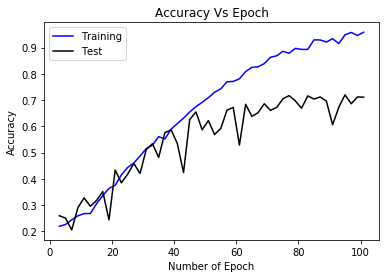

In [ ]:
acc_list_plot= [] 
acc_list2_plot = []
epoch_plot = []
for i in range(len(acc_list)):
  if(i%2!=0):
    acc_list_plot.append(acc_list[i])
    acc_list2_plot.append(acc2_list[i])
    epoch_plot.append(i+2)


fig, ax = plt.subplots()

ax.plot(epoch_plot, acc_list_plot,'-b', label='Training' )
ax.plot(epoch_plot, acc_list2_plot,  '-k', label='Test')


plt.title("Accuracy Vs Epoch")
plt.xlabel("Number of Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

In [ ]:
predicted_train_8000 = []
labels_train_8000 = []

predicted_test_3000 = []
labels_test_3000 = []

predicted_2000 = []
labels_2000 = []
score_max2000 = []

##Training: 
new_model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for j, (images_train, labels_train) in enumerate(train_loader):
            images_train = images_train.to(device)
            labels_train = labels_train.to(device)
            outputs = new_model(images_train)
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels_train.size(0)
            correct_train += (predicted_train == labels_train.long()).sum().item()
            predicted_train_8000.append(predicted_train)
            labels_train_8000.append(labels_train)
            
print('Training Accuracy of the model on the 8000 Training images: {} %'.format((correct_train / total_train) * 100))

##Validation: 
new_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for j, (images_valid, labels_valid) in enumerate(val_loader):
            images_valid = images_valid.to(device)
            labels_valid = labels_valid.to(device)
            outputs2 = new_model(images_valid)
            m = torch.nn.Softmax(dim=1)
            _, predicted_valid = torch.max(outputs2.data, 1)
            total += labels_valid.size(0)
            correct += (predicted_valid == labels_valid.long()).sum().item()
            predicted_2000.append(predicted_valid)
            labels_2000.append(labels_valid)
            score_max2000.append( torch.max(m(outputs2.data), 1))
            
            

    print('Valid Accuracy of the model on the 2000 Valid images: {} %'.format((correct / total) * 100))
    predicted_2000 = torch.cat(predicted_2000).long()
    labels_2000 = torch.cat(labels_2000).long()
    score_max2000_real = []
  
    for i in range(10):
      score_max2000_real.append(score_max2000[i][0])
    
score_max2000_real = torch.cat(score_max2000_real)




Training Accuracy of the model on the 8000 Training images: 95.02000000000001 %
Valid Accuracy of the model on the 2000 Valid images: 71.1 %
1000


[[27, 33, 210, 337, 386, 490, 569, 605, 631, 639, 681, 682, 740, 824, 903, 979], [80, 153, 212, 254, 513, 528, 534, 592, 683, 760, 864, 985], [20, 47, 208, 235, 288, 512, 518, 520, 551, 644, 658, 842, 929], [176, 298, 640, 669, 959, 977], [62, 199, 315, 382, 570, 806, 886], [211, 249, 334, 451], [82, 116, 155, 169, 183, 240, 295, 304, 305, 311, 323, 326, 367, 372, 384, 385, 387, 413, 431, 497, 498, 503, 521, 550, 553, 577, 587, 596, 611, 667, 820, 852, 856, 866, 879, 894, 901, 914, 919, 952], [189, 220, 474, 495, 628, 733, 839, 848, 936], [40, 100, 142, 148, 156, 164, 222, 225, 253, 361, 392, 410, 414, 430, 469, 651, 673, 847, 895, 981], [25, 49, 66, 104, 113, 120, 127, 194, 204, 231, 239, 256, 266, 273, 281, 329, 339, 405, 436, 444, 449, 464, 466, 471, 489, 504, 524, 536, 545, 547, 562, 566, 576, 583, 595, 600, 602, 615, 622, 630, 665, 676, 689, 696, 705, 761, 763, 768, 783, 814, 859, 883, 905, 918, 921, 930, 943, 949, 951, 987]]
Class: 0
2
tensor(1.0000, device='cuda:0')
18
tensor(1.

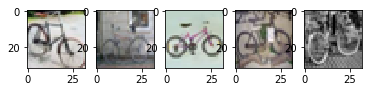

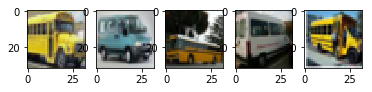

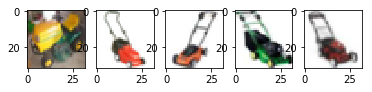

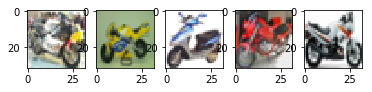

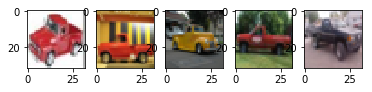

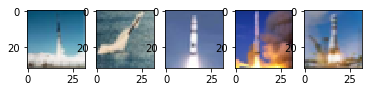

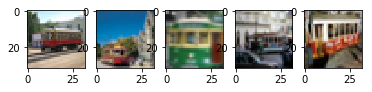

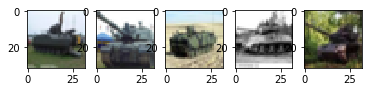

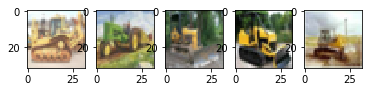

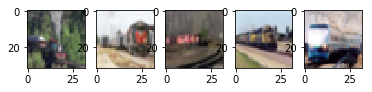

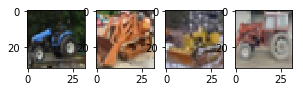

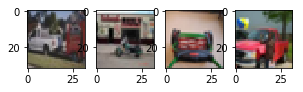

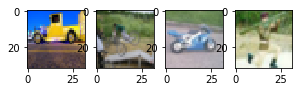

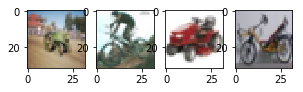

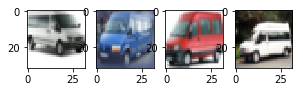

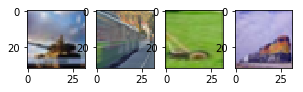

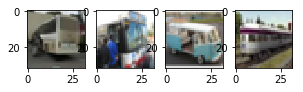

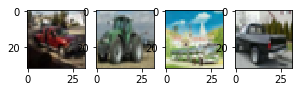

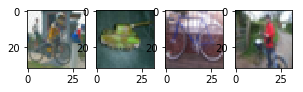

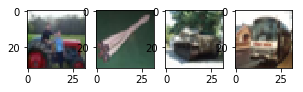

In [ ]:
#Figuring Out how many in each class are correct:
counter_10 = torch.zeros(10,1)
index = [[],[],[],[],[],[],[],[],[],[]]
index2 = [[],[],[],[],[],[],[],[],[],[]]
predicted = predicted_2000
labels_valid = labels_2000
softmax_score =score_max2000_real

#Checking the number of correctly classifed images per class: 
for i in range(1000):
    if(predicted[i]==labels_valid[i]):
        if((predicted[i] == 0) and (softmax_score[i] > 0.99)):
            counter_10[0] = counter_10[0] + 1
            index[0].append(i)
        elif((predicted[i] == 1) and (softmax_score[i] > 0.99)):
            counter_10[1] = counter_10[1] + 1
            index[1].append(i)
        elif((predicted[i] == 2) and (softmax_score[i] > 0.99)):
            counter_10[2] = counter_10[2] + 1
            index[2].append(i)
        elif((predicted[i] == 3) and (softmax_score[i] > 0.99)):
            counter_10[3] = counter_10[3] + 1
            index[3].append(i)
        elif((predicted[i] == 4) and (softmax_score[i] > 0.99)):
            counter_10[4] = counter_10[4] + 1
            index[4].append(i)
        elif((predicted[i] == 5) and (softmax_score[i] > 0.80)):
            counter_10[5] = counter_10[5] + 1
            index[5].append(i)
        elif((predicted[i] == 6) and (softmax_score[i] > 0.80)):
            counter_10[6] = counter_10[6] + 1
            index[6].append(i)
        elif((predicted[i] == 7) and (softmax_score[i] > 0.85)):
            counter_10[7] = counter_10[7] + 1
            index[7].append(i)
        elif((predicted[i] == 8) and (softmax_score[i] > 0.99)):
            counter_10[8] = counter_10[8] + 1
            index[8].append(i)
        elif((predicted[i] == 9) and (softmax_score[i] > 0.99)):
            counter_10[9] = counter_10[9] + 1
            index[9].append(i)
            
            
#Checking the number of incorrectly classified images (but confident): 
for i in range(1000):
    if(predicted[i]!=labels_valid[i]):
        if(predicted[i] == 0):
            if (softmax_score[i] > 0.80 ):
                index2[0].append(i)
        elif(predicted[i] == 1):
            if (softmax_score[i] > 0.80 ):
                index2[1].append(i)
        elif(predicted[i] == 2):
            if (softmax_score[i] > 0.75 ):
                index2[2].append(i)
        elif(predicted[i] == 3):
            if (softmax_score[i] > 0.5 ):
                index2[3].append(i)
        elif(predicted[i] == 4):
            if (softmax_score[i] > 0.80 ):
                index2[4].append(i)
        elif(predicted[i] == 5):
            if (softmax_score[i] > 0.55 ):
                index2[5].append(i)
        elif(predicted[i] == 6):
            if (softmax_score[i] > 0.75 ):
                index2[6].append(i)
        elif(predicted[i] == 7):
            if (softmax_score[i] > 0.75 ):
                index2[7].append(i)
        elif(predicted[i] == 8):
            if (softmax_score[i] > 0.80 ):
                index2[8].append(i)
        else:
            if (softmax_score[i] > 0.60 ):
                index2[9].append(i)
            

            
#Printing Images:

print(index2)


val_loader2 = torch.utils.data.DataLoader(dataset=test_set, 
                                           batch_size=1000, 
                                           shuffle=False)

image_batch, labels = next(iter(val_loader2))

##Printing Correctly Classfied Classes

for categ in range(10):
  plt.figure()
  print('Class:',categ)
  for tmpC1 in range(5):
      position = index[categ][tmpC1]
      print(position)
      print(softmax_score[position])
      img = np.moveaxis(image_batch[position].numpy(),0,2)
      plt.subplot(1,5,tmpC1+1)
      plt.imshow(img/255)
      

##Printing Incorrectly Classified Classes       
      
for categ in range(10):
  plt.figure()
  print('Class:',categ)
  for tmpC1 in range(4):
      position = index2[categ][tmpC1]
      print(position)
      print(softmax_score[position])
      img = np.moveaxis(image_batch[position].numpy(),0,2)
      plt.subplot(1,5,tmpC1+1)
      plt.imshow(img/255)